# SEIR with synthetic data

To-do:

- More smoothing
- Compartwise + all compartments
- Vary time intervals
- More regions
- Check warnings

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd

import datetime
from datetime import timedelta, datetime
import copy
import os
import sys
sys.path.append('../../')

from utils.enums import Columns
from utils.util import read_config, train_test_split
from utils.data import cities
from utils.loss import Loss_Calculator

from data.dataloader import Covid19IndiaLoader
from data.processing import get_dataframes_cached, get_data

from main.ihme.fitting import single_cycle, create_output_folder
from main.seir.fitting import get_regional_data, data_setup, run_cycle

from models.seir.seir_testing import SEIR_Testing
from main.seir.forecast import get_forecast

from viz.forecast import plot_forecast_agnostic
from viz.fit import plot_fit

## Functions to create custom dataset

In [3]:
def get_custom_dataset(df_actual, df_synthetic, use_actual=True, use_synthetic=True,
                       start_date=None, allowance=5, split1=15, split2=15, split3=15):

    if start_date is None:
        start_date = df_actual['date'].min()
    else:
        start_date = pd.to_datetime(start_date, dayfirst=False)
        
    threshold = start_date - timedelta(days=1)

    _, df_actual = train_test_split(df_actual, threshold)
    _, df_synthetic = train_test_split(df_synthetic, threshold)
        
    test_size = split3
    end_of_train = start_date + timedelta(allowance+split1+split2 - 1)
    
    properties = {
        "total_length": split1+split2+split3,
        "train_length": split1+split2,
        "test_length": test_size,
        "train_actual_length": split1,
        "train_synthetic_length": split2
    }
    
    df_train, df_test = train_test_split(df_actual, end_of_train)

    if not use_synthetic:  
        pass
    elif not use_actual:
        df_train, _ = train_test_split(df_synthetic, end_of_train)
    elif use_actual and use_synthetic:
        end_of_actual = start_date + timedelta(split1 + allowance - 1)
        df_train1, _ = train_test_split(df_actual, end_of_actual)
        df_train_temp, _ = train_test_split(df_synthetic, end_of_train)
        _, df_train2 = train_test_split(df_train_temp, end_of_actual)
        df_train = pd.concat([df_train1, df_train2], axis=0)
    else:
        raise Exception("Train and test sets not defined.")

    if len(df_test) > test_size:
        df_test = df_test.head(test_size)
    else:
        raise Exception("Test set size {} greater than size available {}.".format(test_size, len(df_test)))
        
    df_train.reset_index(inplace=True, drop=True)
        
    df = pd.concat([df_train, df_test], axis=0)
    
    return df, df_train, df_test, properties

In [4]:
def format_custom_dataset(dataset, state=None, district=None, compartments=Columns.curve_fit_compartments()):
    """Format custom dataset according to the format required by the SEIR model. Select/insert required columns."""
    col_names = [col.name for col in compartments]
    dataset = dataset[['date']+col_names]
    if state:
        dataset.insert(1, "state", state)
    if district:
        dataset.insert(2, "district", district)
    return dataset

In [5]:
def insert_custom_dataset_into_dataframes(dataframes, dataset, start_date=None, compartments=None):
    """Replace original df_district with one or more columns from custom dataset."""
    if compartments is None:
        compartments = Columns.curve_fit_compartments()
        col_names = [col.name for col in compartments]
    else:
        col_names = compartments
        
    df_district, df_raw = dataframes
    
    if start_date is None:
        start_date = df_district['date'].min()
    else:
        start_date = pd.to_datetime(start_date, dayfirst=False)
    
    threshold = start_date - timedelta(days=1)

    _, df_district = train_test_split(df_district, threshold)
    _, df_raw = train_test_split(df_raw, threshold)
    
    num_rows = dataset.shape[0]
    df_district = df_district.head(num_rows)
    for col in col_names:
        df_district[col] = dataset[col].values
    return (df_district, df_raw)

## Check data

In [6]:
district = 'Pune'
state = 'Maharashtra'
disable_tracker = True
allowance = 5 # number of days of actuals to have before s1 starts for rolling average

In [7]:
loader = Covid19IndiaLoader()
dataframes = loader.get_covid19india_api_data()

data = get_data(dataframes, state, district, disable_tracker=disable_tracker)
data

fetching from athenadb...


,state,district,date,total_infected,hospitalised,recovered,deceased
0,maharashtra,pune,2020-04-19,586,482,55,49
1,maharashtra,pune,2020-04-20,666,549,68,49
2,maharashtra,pune,2020-04-21,708,570,87,51
3,maharashtra,pune,2020-04-22,772,595,122,55
4,maharashtra,pune,2020-04-23,876,687,130,59
...,...,...,...,...,...,...,...
59,maharashtra,pune,2020-06-17,10643,3449,6713,481
60,maharashtra,pune,2020-06-18,11115,3722,6906,487
61,maharashtra,pune,2020-06-19,11465,3909,7063,493
62,maharashtra,pune,2020-06-20,11854,4086,7264,504


## Setup

In [8]:
start_date = data['date'].min()
ihme_start_date = start_date + timedelta(allowance)
# Allow for a few days of actuals before s1 for rolling average
period = 30
smooth_jump = True if district == "Mumbai" else False

In [9]:
now = datetime.now().strftime("%Y%m%d-%H%M%S")
folder = f'{district}/{str(now)}'
output_folder = create_output_folder(f'synth/{folder}')

## IHME model (I1)

### Setup

In [10]:
dist, st, area_names = cities[district.lower()]
config, model_params = read_config('../../scripts/ihme/config/default.yaml')
config['start_date'] = ihme_start_date
config['period'] = period
config['disable_tracker'] = disable_tracker
config['max_evals'] = 100

### Train

In [11]:
ihme_res = single_cycle(dist, st, area_names, model_params, **config)

../../cache/Pune_ts_athena_24062020.pkl
  1%|          | 1/100 [00:00<01:05,  1.52trial/s, best loss: 2.719400087917033]

/Users/nayana/anaconda3/envs/covid/lib/python3.8/site-packages/pandas/core/series.py:679: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)



 48%|████▊     | 48/100 [01:39<01:57,  2.25s/trial, best loss: 2.191661746534967] 

/Users/nayana/anaconda3/envs/covid/lib/python3.8/site-packages/curvefit-0.0.0-py3.8.egg/curvefit/core/functions.py:55: RuntimeWarning: divide by zero encountered in log
  result[zidx] = np.log(params[2][zidx]/2) - x[zidx]**2 - \

/Users/nayana/anaconda3/envs/covid/lib/python3.8/site-packages/curvefit-0.0.0-py3.8.egg/curvefit/core/model.py:202: RuntimeWarning: invalid value encountered in true_divide
  residual = (self.obs - self.fun(self.t, params))/self.obs_se



100%|██████████| 100/100 [03:13<00:00,  1.93s/trial, best loss: 2.191661746534967]
Running PV for 1.0
100%|██████████| 100/100 [01:11<00:00,  1.39trial/s, best loss: 0.25887477538160575]
Running PV for 1.0


/Users/nayana/anaconda3/envs/covid/lib/python3.8/site-packages/curvefit-0.0.0-py3.8.egg/curvefit/core/functions.py:92: RuntimeWarning: overflow encountered in square
  return 0.5*sum(x**2)
/Users/nayana/anaconda3/envs/covid/lib/python3.8/site-packages/curvefit-0.0.0-py3.8.egg/curvefit/core/functions.py:92: RuntimeWarning: invalid value encountered in cdouble_scalars
  return 0.5*sum(x**2)


  2%|▏         | 2/100 [00:01<01:06,  1.47trial/s, best loss: 0.7842282898268618]

../../models/ihme/model.py:71: RuntimeWarning: overflow encountered in exp
  exp_fun = lambda x : np.exp(x)

/Users/nayana/anaconda3/envs/covid/lib/python3.8/site-packages/curvefit-0.0.0-py3.8.egg/curvefit/core/functions.py:43: RuntimeWarning: invalid value encountered in multiply
  return 0.5*params[2]*(special.erf(params[0]*(t - params[1])) + 1.0)

/Users/nayana/anaconda3/envs/covid/lib/python3.8/site-packages/curvefit-0.0.0-py3.8.egg/curvefit/core/functions.py:49: RuntimeWarning: invalid value encountered in multiply
  x = params[0]*(t - params[1])



100%|██████████| 100/100 [01:13<00:00,  1.36trial/s, best loss: 0.7842000455454945]
Running PV for 1.0
100%|██████████| 100/100 [01:10<00:00,  1.42trial/s, best loss: 0.3220542458139311]
Running PV for 1.0


### Outputs

In [12]:
res = copy.copy(ihme_res)

In [13]:
%matplotlib inline
ihme_df_train, ihme_df_val = ihme_res['df_train'], ihme_res['df_test']
ihme_df_train_nora, ihme_df_val_nora = ihme_res['df_train_nora'], ihme_res['df_test_nora']
ihme_df_true = ihme_res['df_district']
ihme_df_pred = ihme_res['df_prediction']

makesum = copy.copy(ihme_df_pred)
makesum['total_infected'] = ihme_df_pred['recovered'] + ihme_df_pred['deceased'] + ihme_df_pred['hospitalised']

plot_fit(
    makesum.reset_index(), ihme_df_train, ihme_df_val, ihme_df_train_nora, ihme_df_val_nora, 
    15, st, dist, which_compartments=[c.name for c in Columns.curve_fit_compartments()],
    savepath=os.path.join(output_folder, 'm1.png'))

plot_forecast_agnostic(ihme_df_true, makesum.reset_index(), model_name='IHME M1', dist=dist, state=st, filename=os.path.join(output_folder, 'm1-forecast.png'))

,date,recovered,deceased,hospitalised,total_infected,log_recovered_rate,log_deceased_rate,log_hospitalised_rate,log_total_infected_rate
0,2020-04-24,132.152395,62.108718,766.977944,976.993612,-11.175388,-11.930458,-9.416886,-9.174864
1,2020-04-25,150.019358,65.859280,842.291024,1061.963355,-11.048580,-11.871824,-9.323218,-9.091469
2,2020-04-26,170.246316,69.772789,914.774632,1149.524852,-10.922098,-11.814100,-9.240666,-9.012240
3,2020-04-27,193.136679,73.851856,983.195063,1239.232219,-10.795946,-11.757283,-9.168536,-8.937097
4,2020-04-28,219.033009,78.098832,1046.539492,1330.603369,-10.670121,-11.701369,-9.106100,-8.865956
5,2020-04-29,248.319462,82.515790,1104.058005,1423.127739,-10.544628,-11.646354,-9.052596,-8.798732
6,2020-04-30,281.429131,87.104506,1155.283184,1516.274816,-10.419463,-11.592235,-9.007243,-8.735332
7,2020-05-01,318.847719,91.866442,1200.027298,1609.503249,-10.294630,-11.539008,-8.969244,-8.675663
8,2020-05-02,361.123321,96.802729,1238.359605,1702.270267,-10.170124,-11.486669,-8.937801,-8.619626
9,2020-05-03,408.867652,101.914151,1270.568111,1794.041138,-10.045952,-11.435213,-8.912124,-8.567118


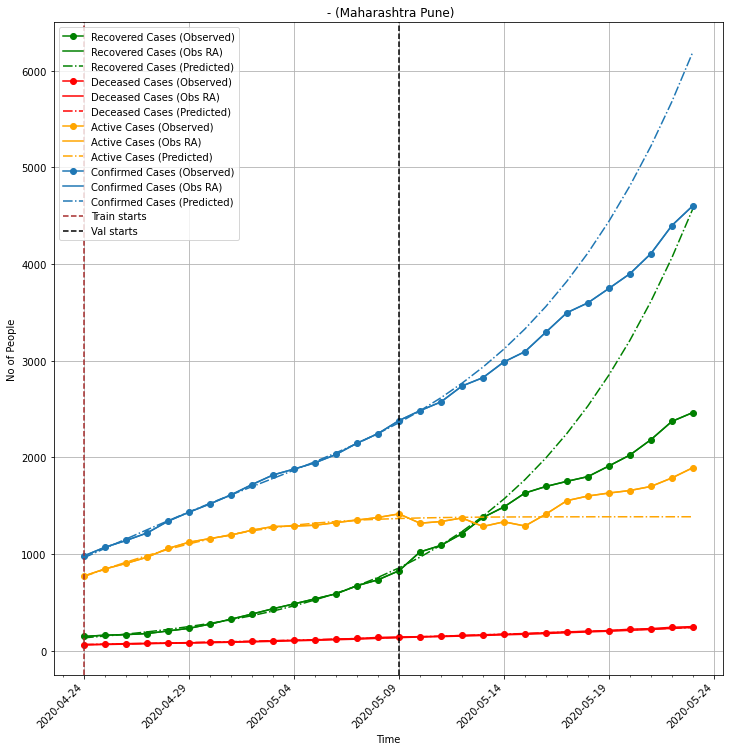

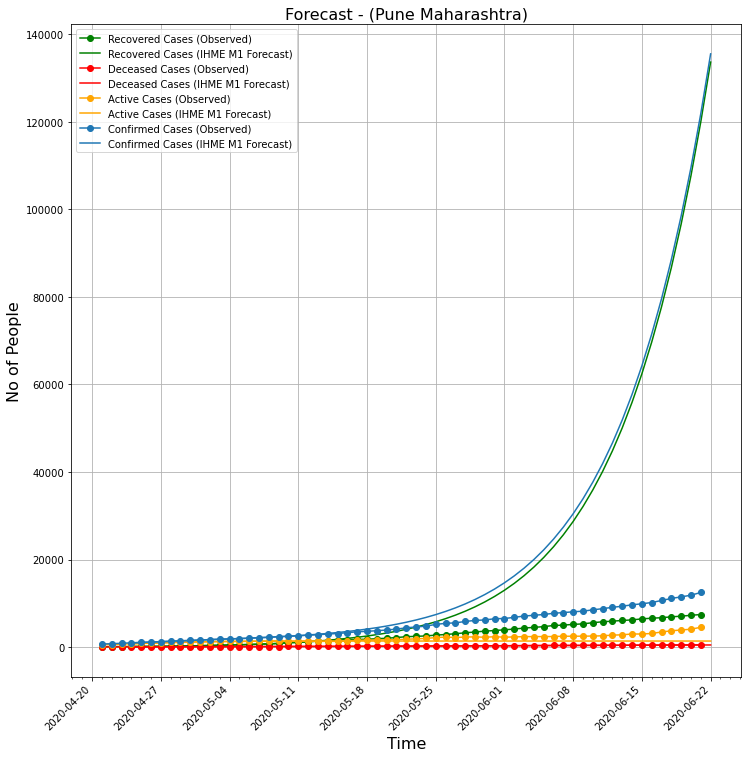

In [14]:
ihme_res['df_prediction']

In [15]:
ihme_res['df_train']

,recovered,deceased,hospitalised,total_infected,log_recovered_rate,log_deceased_rate,log_hospitalised_rate,log_total_infected_rate,date
3,146,58.666667,772,980,-11.075737,-11.932209,-9.410359,-9.171791,2020-04-24
4,159,62.333333,845,1070,-10.990440,-11.869689,-9.320007,-9.083930,2020-04-25
5,165,66.666667,902,1139,-10.953398,-11.782678,-9.254729,-9.021438,2020-04-26
6,176,71.000000,966,1217,-10.888860,-11.741856,-9.186180,-8.955200,2020-04-27
7,203,75.333333,1057,1339,-10.746138,-11.689896,-9.096154,-8.859666,2020-04-28
8,230,78.333333,1121,1432,-10.621265,-11.664895,-9.037367,-8.792517,2020-04-29
9,274,81.666667,1159,1518,-10.446216,-11.616693,-9.004031,-8.734195,2020-04-30
10,325,85.666667,1195,1611,-10.275519,-11.548484,-8.973442,-8.674733,2020-05-01
11,378,90.000000,1246,1718,-10.124450,-11.516049,-8.931650,-8.610428,2020-05-02
12,433,95.333333,1283,1817,-9.988606,-11.444223,-8.902388,-8.554402,2020-05-03


In [16]:
ihme_res['df_test']

,recovered,deceased,hospitalised,total_infected,log_recovered_rate,log_deceased_rate,log_hospitalised_rate,log_total_infected_rate,date
18,826,133.666667,1414,2380,-9.342749,-11.117701,-8.805166,-8.284488,2020-05-09
19,1020,140.000000,1318,2482,-9.131786,-11.089531,-8.875473,-8.242524,2020-05-10
20,1089,144.333333,1335,2573,-9.066329,-11.055398,-8.862657,-8.206516,2020-05-11
21,1209,149.666667,1372,2737,-8.961795,-11.009488,-8.835319,-8.144726,2020-05-12
22,1377,156.000000,1284,2824,-8.831681,-10.965594,-8.901608,-8.113434,2020-05-13
23,1486,162.666667,1332,2987,-8.755501,-10.929445,-8.864907,-8.057319,2020-05-14
24,1630,168.666667,1289,3093,-8.663009,-10.900289,-8.897722,-8.022447,2020-05-15
25,1698,176.000000,1412,3295,-8.622138,-10.838988,-8.806581,-7.959182,2020-05-16
26,1751,184.333333,1551,3496,-8.591402,-10.791486,-8.712689,-7.899969,2020-05-17
27,1800,192.666667,1599,3598,-8.563802,-10.766039,-8.682210,-7.871210,2020-05-18


In [17]:
ihme_res['df_loss']

,train,test,train_no_xform,test_no_xform
recovered,4.61269,19.2104,0.439059,2.93922
deceased,1.49642,1.45888,0.129651,0.13379
hospitalised,0.907929,12.2456,0.100631,1.27036
total_infected,0.800216,23.917,0.0923208,2.53407


In [18]:
ihme_res['df_district_nora']

,recovered,deceased,hospitalised,total_infected,log_recovered_rate,log_deceased_rate,log_hospitalised_rate,log_total_infected_rate,date
0,55,49,482,586,-12.052011,-12.167524,-9.881400,-9.686024,2020-04-19
1,68,49,549,666,-11.839836,-12.167524,-9.751245,-9.558054,2020-04-20
2,87,51,570,708,-11.593436,-12.127518,-9.713708,-9.496900,2020-04-21
3,122,55,595,772,-11.255323,-12.052011,-9.670782,-9.410359,2020-04-22
4,130,59,687,876,-11.191809,-11.981806,-9.527010,-9.283978,2020-04-23
...,...,...,...,...,...,...,...,...,...
59,6713,481,3449,10643,-7.247543,-9.883477,-7.913504,-6.786686,2020-06-17
60,6906,487,3722,11115,-7.219198,-9.871080,-7.837327,-6.743293,2020-06-18
61,7063,493,3909,11465,-7.196719,-9.858835,-7.788307,-6.712290,2020-06-19
62,7264,504,4086,11854,-7.168658,-9.836768,-7.744022,-6.678923,2020-06-20


## SEIR model (C1)

### Setup

In [19]:
c1_input = get_regional_data(dataframes, st, dist, (not disable_tracker), None, None, granular_data=False, 
                             smooth_jump=smooth_jump, smoothing_length=33, smoothing_method='weighted', t_recov=14,
                             return_extra=False)
c1_input

fetching from athenadb...


(          state district       date  total_infected  hospitalised  recovered  \
 0   maharashtra     pune 2020-04-19             586           482         55   
 1   maharashtra     pune 2020-04-20             666           549         68   
 2   maharashtra     pune 2020-04-21             708           570         87   
 3   maharashtra     pune 2020-04-22             772           595        122   
 4   maharashtra     pune 2020-04-23             876           687        130   
 ..          ...      ...        ...             ...           ...        ...   
 59  maharashtra     pune 2020-06-17           10643          3449       6713   
 60  maharashtra     pune 2020-06-18           11115          3722       6906   
 61  maharashtra     pune 2020-06-19           11465          3909       7063   
 62  maharashtra     pune 2020-06-20           11854          4086       7264   
 63  maharashtra     pune 2020-06-21           12474          4529       7435   
 
     deceased  
 0        

In [20]:
model=SEIR_Testing
variable_param_ranges=None
data_from_tracker=False
granular_data=False
filename=None
data_format='new'
train_period=15
val_period=15
num_evals=1500
N=1e7
initialisation='intermediate'
which_compartments=['hospitalised', 'total_infected', 'deceased', 'recovered']
smooth_jump=False
smoothing_length=33
smoothing_method='weighted'

In [21]:
c1_df_district, c1_df_raw = c1_input
c1_df_district = c1_df_district.head(train_period+val_period+allowance)

print(c1_df_district)

predictions_dict_c1 = dict()

observed_dataframes = data_setup(c1_df_district, c1_df_raw, val_period)

print('train\n', observed_dataframes['df_train'])
print('val\n', observed_dataframes['df_val'])

          state district       date  total_infected  hospitalised  recovered  \
0   maharashtra     pune 2020-04-19             586           482         55   
1   maharashtra     pune 2020-04-20             666           549         68   
2   maharashtra     pune 2020-04-21             708           570         87   
3   maharashtra     pune 2020-04-22             772           595        122   
4   maharashtra     pune 2020-04-23             876           687        130   
5   maharashtra     pune 2020-04-24             980           772        146   
6   maharashtra     pune 2020-04-25            1070           845        159   
7   maharashtra     pune 2020-04-26            1139           902        165   
8   maharashtra     pune 2020-04-27            1217           966        176   
9   maharashtra     pune 2020-04-28            1339          1057        203   
10  maharashtra     pune 2020-04-29            1432          1121        230   
11  maharashtra     pune 2020-04-30     

### Train

100%|██████████| 1500/1500 [02:10<00:00, 11.46trial/s, best loss: 15.63301151686106]
best parameters
 {'E_hosp_ratio': 0.07928389141173459, 'I_hosp_ratio': 0.6755711318103024, 'P_fatal': 0.13767855340729696, 'T_inc': 4.573328001679851, 'T_inf': 3.877343336742144, 'T_recov_severe': 28.0837347393941, 'lockdown_R0': 1.2087780613062744}


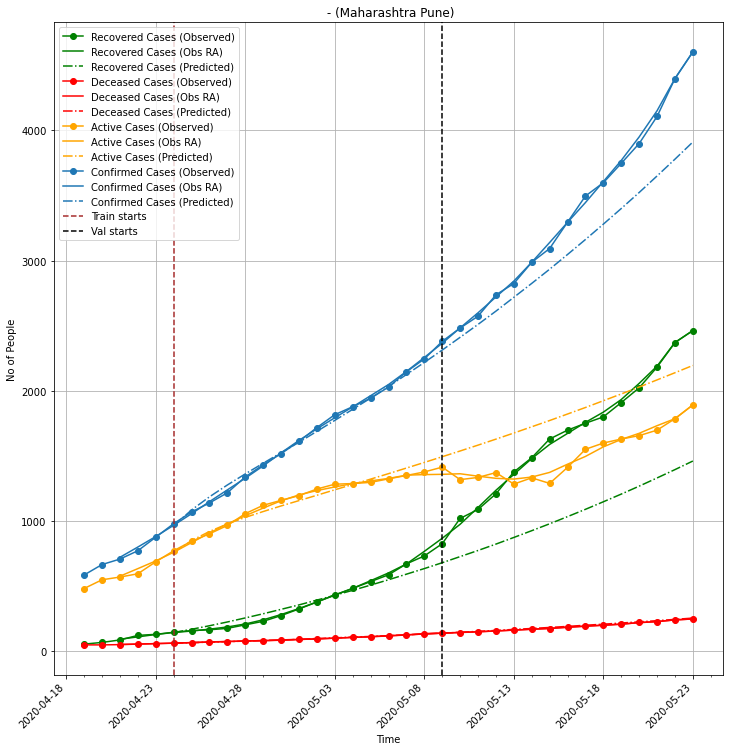

In [22]:
predictions_dict_c1['m1'] = run_cycle(
        st, dist, observed_dataframes, 
        model=model, variable_param_ranges=variable_param_ranges,
        data_from_tracker=data_from_tracker, train_period=train_period, 
        which_compartments=which_compartments, N=N,
        num_evals=num_evals, initialisation=initialisation
    )

### Outputs

In [23]:
predictions_dict_c1['m1']['df_prediction']

,date,S,E,I,D_E,D_I,R_mild,R_severe,R_fatal,C,D,hospitalised,recovered,deceased,total_infected
0,2020-04-24,9998458,60,513,0,0,0,655,104,144,62,759,144,62,965
1,2020-04-25,9998314,177,421,0,0,0,733,117,169,66,850,169,66,1085
2,2020-04-26,9998192,252,367,0,0,0,793,127,196,70,920,196,70,1186
3,2020-04-27,9998083,300,338,0,0,0,842,136,225,74,978,225,74,1277
4,2020-04-28,9997979,334,322,0,0,0,885,143,256,78,1028,256,78,1362
5,2020-04-29,9997880,358,315,0,0,0,923,150,288,83,1073,288,83,1444
6,2020-04-30,9997782,375,315,0,0,0,960,156,322,87,1116,322,87,1525
7,2020-05-01,9997684,389,317,0,0,0,995,162,356,92,1157,356,92,1605
8,2020-05-02,9997584,402,321,0,0,0,1030,168,393,98,1198,393,98,1689
9,2020-05-03,9997483,414,327,0,0,0,1065,175,430,103,1240,430,103,1773


In [24]:
predictions_dict_c1['m1']['df_val']

,state,district,date,total_infected,hospitalised,recovered,deceased
0,maharashtra,pune,2020-05-09,2365.2,1358.8,867.6,138.8
1,maharashtra,pune,2020-05-10,2483.4,1363.2,975.2,145.0
2,maharashtra,pune,2020-05-11,2599.2,1344.6,1104.2,150.4
3,maharashtra,pune,2020-05-12,2720.6,1328.2,1236.2,156.2
4,maharashtra,pune,2020-05-13,2842.8,1322.4,1358.2,162.2
5,maharashtra,pune,2020-05-14,2987.2,1337.8,1480.0,169.4
6,maharashtra,pune,2020-05-15,3139.0,1373.6,1588.4,177.0
7,maharashtra,pune,2020-05-16,3293.8,1436.6,1673.0,184.2
8,maharashtra,pune,2020-05-17,3445.8,1496.2,1757.8,191.8
9,maharashtra,pune,2020-05-18,3607.0,1569.6,1836.4,201.2


In [25]:
predictions_dict_c1['m1']['df_loss']

,train,val
hospitalised,2.78977,17.7167
total_infected,1.51198,8.27072
deceased,1.76612,2.9065
recovered,10.5289,55.7213


## Create custom datasets

In [26]:
df1, train1, test1, _ = get_custom_dataset(ihme_res['df_district_nora'], ihme_res['df_prediction'], 
                                           use_synthetic=False, start_date=start_date)
train1 = format_custom_dataset(train1, st, dist)
df1 = format_custom_dataset(df1, st, dist)
train1

,date,state,district,recovered,deceased,hospitalised,total_infected
0,2020-04-19,Maharashtra,Pune,55,49,482,586
1,2020-04-20,Maharashtra,Pune,68,49,549,666
2,2020-04-21,Maharashtra,Pune,87,51,570,708
3,2020-04-22,Maharashtra,Pune,122,55,595,772
4,2020-04-23,Maharashtra,Pune,130,59,687,876
5,2020-04-24,Maharashtra,Pune,146,62,772,980
6,2020-04-25,Maharashtra,Pune,159,66,845,1070
7,2020-04-26,Maharashtra,Pune,165,72,902,1139
8,2020-04-27,Maharashtra,Pune,176,75,966,1217
9,2020-04-28,Maharashtra,Pune,203,79,1057,1339


In [27]:
df2, train2, test2, _ = get_custom_dataset(ihme_res['df_district_nora'], ihme_res['df_prediction'],
                                           start_date=start_date)
train2 = format_custom_dataset(train2, st, dist)
df2 = format_custom_dataset(df2, st, dist)
train2

,date,state,district,recovered,deceased,hospitalised,total_infected
0,2020-04-19,Maharashtra,Pune,55.000000,49.000000,482.000000,586.000000
1,2020-04-20,Maharashtra,Pune,68.000000,49.000000,549.000000,666.000000
2,2020-04-21,Maharashtra,Pune,87.000000,51.000000,570.000000,708.000000
3,2020-04-22,Maharashtra,Pune,122.000000,55.000000,595.000000,772.000000
4,2020-04-23,Maharashtra,Pune,130.000000,59.000000,687.000000,876.000000
5,2020-04-24,Maharashtra,Pune,146.000000,62.000000,772.000000,980.000000
6,2020-04-25,Maharashtra,Pune,159.000000,66.000000,845.000000,1070.000000
7,2020-04-26,Maharashtra,Pune,165.000000,72.000000,902.000000,1139.000000
8,2020-04-27,Maharashtra,Pune,176.000000,75.000000,966.000000,1217.000000
9,2020-04-28,Maharashtra,Pune,203.000000,79.000000,1057.000000,1339.000000


In [28]:
df3, train3, test3, _= get_custom_dataset(ihme_res['df_district_nora'], predictions_dict_c1['m1']['df_prediction'], 
                                          start_date=start_date)
train3 = format_custom_dataset(train3, st, dist)
df3 = format_custom_dataset(df3, st, dist)

### Save custom datasets

In [29]:
df1.to_csv(output_folder+"/Dataset1.csv")
df2.to_csv(output_folder+"/Dataset2.csv")
df3.to_csv(output_folder+"/Dataset3.csv")

## SEIR Model using custom datasets

### Setup

In [51]:
input_df = get_regional_data(dataframes, st, dist, (not disable_tracker), None, None, granular_data=False, 
                             smooth_jump=smooth_jump, smoothing_length=33, smoothing_method='weighted', t_recov=14,
                             return_extra=False)

replace = ['deceased']

fetching from athenadb...


In [52]:
input_1 = insert_custom_dataset_into_dataframes(input_df, df1, 
                                                start_date=start_date, compartments=replace)
input_1

(          state district       date  total_infected  hospitalised  recovered  \
 0   maharashtra     pune 2020-04-19             586           482         55   
 1   maharashtra     pune 2020-04-20             666           549         68   
 2   maharashtra     pune 2020-04-21             708           570         87   
 3   maharashtra     pune 2020-04-22             772           595        122   
 4   maharashtra     pune 2020-04-23             876           687        130   
 5   maharashtra     pune 2020-04-24             980           772        146   
 6   maharashtra     pune 2020-04-25            1070           845        159   
 7   maharashtra     pune 2020-04-26            1139           902        165   
 8   maharashtra     pune 2020-04-27            1217           966        176   
 9   maharashtra     pune 2020-04-28            1339          1057        203   
 10  maharashtra     pune 2020-04-29            1432          1121        230   
 11  maharashtra     pune 20

In [53]:
input_2 = insert_custom_dataset_into_dataframes(input_df, df2, 
                                                start_date=start_date, compartments=replace)
input_2

(          state district       date  total_infected  hospitalised  recovered  \
 0   maharashtra     pune 2020-04-19             586           482         55   
 1   maharashtra     pune 2020-04-20             666           549         68   
 2   maharashtra     pune 2020-04-21             708           570         87   
 3   maharashtra     pune 2020-04-22             772           595        122   
 4   maharashtra     pune 2020-04-23             876           687        130   
 5   maharashtra     pune 2020-04-24             980           772        146   
 6   maharashtra     pune 2020-04-25            1070           845        159   
 7   maharashtra     pune 2020-04-26            1139           902        165   
 8   maharashtra     pune 2020-04-27            1217           966        176   
 9   maharashtra     pune 2020-04-28            1339          1057        203   
 10  maharashtra     pune 2020-04-29            1432          1121        230   
 11  maharashtra     pune 20

In [54]:
input_3 = insert_custom_dataset_into_dataframes(input_df, df3, 
                                                start_date=start_date, compartments=replace)
input_3

(          state district       date  total_infected  hospitalised  recovered  \
 0   maharashtra     pune 2020-04-19             586           482         55   
 1   maharashtra     pune 2020-04-20             666           549         68   
 2   maharashtra     pune 2020-04-21             708           570         87   
 3   maharashtra     pune 2020-04-22             772           595        122   
 4   maharashtra     pune 2020-04-23             876           687        130   
 5   maharashtra     pune 2020-04-24             980           772        146   
 6   maharashtra     pune 2020-04-25            1070           845        159   
 7   maharashtra     pune 2020-04-26            1139           902        165   
 8   maharashtra     pune 2020-04-27            1217           966        176   
 9   maharashtra     pune 2020-04-28            1339          1057        203   
 10  maharashtra     pune 2020-04-29            1432          1121        230   
 11  maharashtra     pune 20

In [55]:
model=SEIR_Testing
variable_param_ranges=None
data_from_tracker=(not disable_tracker)
granular_data=False
filename=None
data_format='new'
train_period=30
val_period=15
num_evals=1500
N=1e7
initialisation='intermediate'
which_compartments=['hospitalised', 'total_infected', 'deceased', 'recovered']
smooth_jump=smooth_jump
smoothing_length=33
smoothing_method='weighted'

### Experiment 1 - Ground truth data

splitting data ..
splitting data ..
100%|██████████| 1500/1500 [02:35<00:00,  9.65trial/s, best loss: 31.847891939806097]
best parameters
 {'E_hosp_ratio': 0.5518050783942884, 'I_hosp_ratio': 0.4383019437843635, 'P_fatal': 0.12790197999623137, 'T_inc': 4.9124739611294626, 'T_inf': 3.4268895018617567, 'T_recov_severe': 18.62644582294556, 'lockdown_R0': 1.0833342561421022}


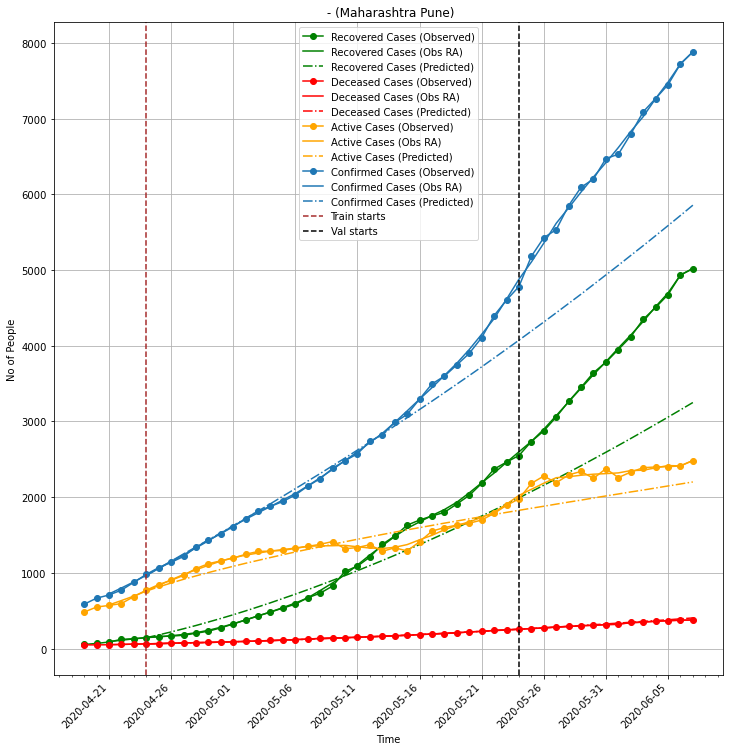

In [56]:
predictions_dict_1 = dict()

observed_dataframes = data_setup(input_1[0], input_1[1], val_period)

# print('train\n', observed_dataframes['df_train'])
# print('val\n', observed_dataframes['df_val'])

predictions_dict_1['m1'] = run_cycle(
        st, dist, observed_dataframes, 
        model=model, variable_param_ranges=variable_param_ranges,
        data_from_tracker=data_from_tracker, train_period=train_period, 
        which_compartments=which_compartments, N=N,
        num_evals=num_evals, initialisation=initialisation
    )

In [57]:
predictions_dict_1['m1']['df_train']

,state,district,date,total_infected,hospitalised,recovered,deceased
0,maharashtra,pune,2020-04-21,721.6,576.6,92.4,52.6
1,maharashtra,pune,2020-04-22,800.4,634.6,110.6,55.2
2,maharashtra,pune,2020-04-23,881.2,693.8,128.8,58.6
3,maharashtra,pune,2020-04-24,967.4,760.2,144.4,62.8
4,maharashtra,pune,2020-04-25,1056.4,834.4,155.2,66.8
5,maharashtra,pune,2020-04-26,1149.0,908.4,169.8,70.8
6,maharashtra,pune,2020-04-27,1239.4,978.2,186.6,74.6
7,maharashtra,pune,2020-04-28,1329.0,1041.0,209.6,78.4
8,maharashtra,pune,2020-04-29,1423.4,1099.6,241.6,82.2
9,maharashtra,pune,2020-04-30,1523.6,1155.6,282.0,86.0


In [58]:
predictions_dict_1['m1']['df_val']

,state,district,date,total_infected,hospitalised,recovered,deceased
0,maharashtra,pune,2020-05-24,4878.2,2023.2,2598.8,256.2
1,maharashtra,pune,2020-05-25,5105.2,2104.0,2736.4,264.8
2,maharashtra,pune,2020-05-26,5354.8,2184.4,2896.6,273.8
3,maharashtra,pune,2020-05-27,5617.0,2257.0,3076.6,283.4
4,maharashtra,pune,2020-05-28,5821.0,2270.2,3258.4,292.4
5,maharashtra,pune,2020-05-29,6030.0,2289.6,3439.8,300.6
6,maharashtra,pune,2020-05-30,6229.2,2303.4,3618.0,307.8
7,maharashtra,pune,2020-05-31,6418.0,2310.8,3789.0,318.2
8,maharashtra,pune,2020-06-01,6617.2,2320.6,3968.6,328.0
9,maharashtra,pune,2020-06-02,6830.0,2350.8,4140.8,338.4


In [59]:
t1 = predictions_dict_1['m1']['df_loss'].T[['hospitalised', 'deceased', 'recovered', 'total_infected']]
t1['exp'] = 1
predictions_dict_1['m1']['df_loss']

,train,val
hospitalised,6.79615,14.4589
total_infected,3.55502,29.2942
deceased,1.32455,2.21256
recovered,20.281,44.4837


### Experiment 2 - Ground truth + IHME forecast

splitting data ..
splitting data ..
100%|██████████| 1500/1500 [02:30<00:00,  9.98trial/s, best loss: 32.25466988014696]
best parameters
 {'E_hosp_ratio': 0.555133858718832, 'I_hosp_ratio': 0.3812090900156961, 'P_fatal': 0.12744834891776508, 'T_inc': 4.809364050828899, 'T_inf': 3.0956426528291443, 'T_recov_severe': 18.85073279680695, 'lockdown_R0': 1.0548774125795508}


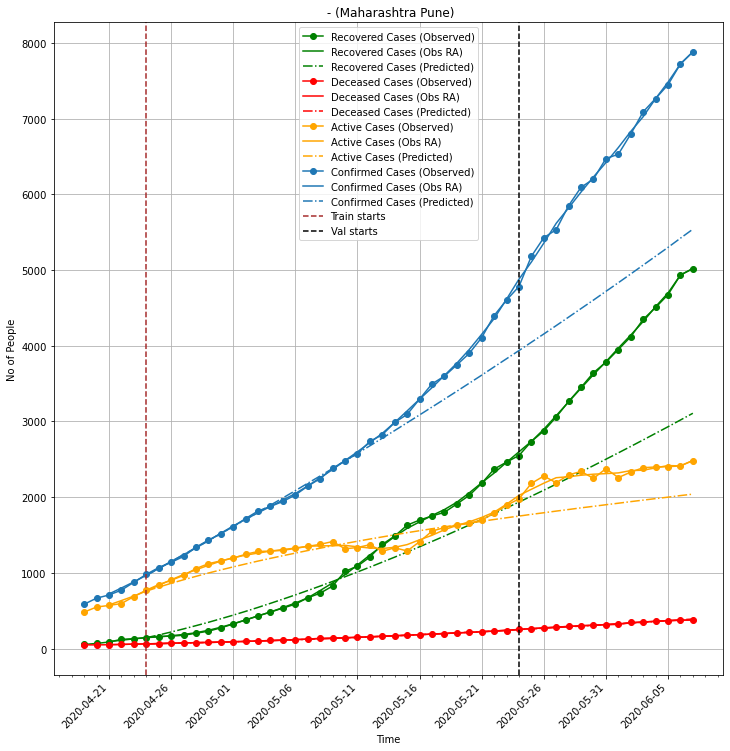

In [60]:
predictions_dict_2 = dict()

observed_dataframes = data_setup(input_2[0], input_2[1], val_period)

# print('train\n', observed_dataframes['df_train']) 
# print('val\n', observed_dataframes['df_val'])

predictions_dict_2['m1'] = run_cycle(
        st, dist, observed_dataframes, 
        model=model, variable_param_ranges=variable_param_ranges,
        data_from_tracker=data_from_tracker, train_period=train_period, 
        which_compartments=which_compartments, N=N,
        num_evals=num_evals, initialisation=initialisation
    )

In [61]:
t2 = predictions_dict_2['m1']['df_loss'].T[['hospitalised', 'deceased', 'recovered', 'total_infected']]
t2['exp'] = 2
predictions_dict_2['m1']['df_loss']

,train,val
hospitalised,6.63529,21.4032
total_infected,4.28086,35.2644
deceased,1.27309,1.56967
recovered,21.0807,49.8866


### Experiment 3 - Ground truth + SEIR forecast

splitting data ..
splitting data ..
100%|██████████| 1500/1500 [02:30<00:00,  9.96trial/s, best loss: 33.33700802429268]
best parameters
 {'E_hosp_ratio': 0.06792092862727775, 'I_hosp_ratio': 0.7829014016732465, 'P_fatal': 0.1316712291286044, 'T_inc': 4.742468807359291, 'T_inf': 3.675532376785586, 'T_recov_severe': 19.437263888951964, 'lockdown_R0': 1.1263200208271213}


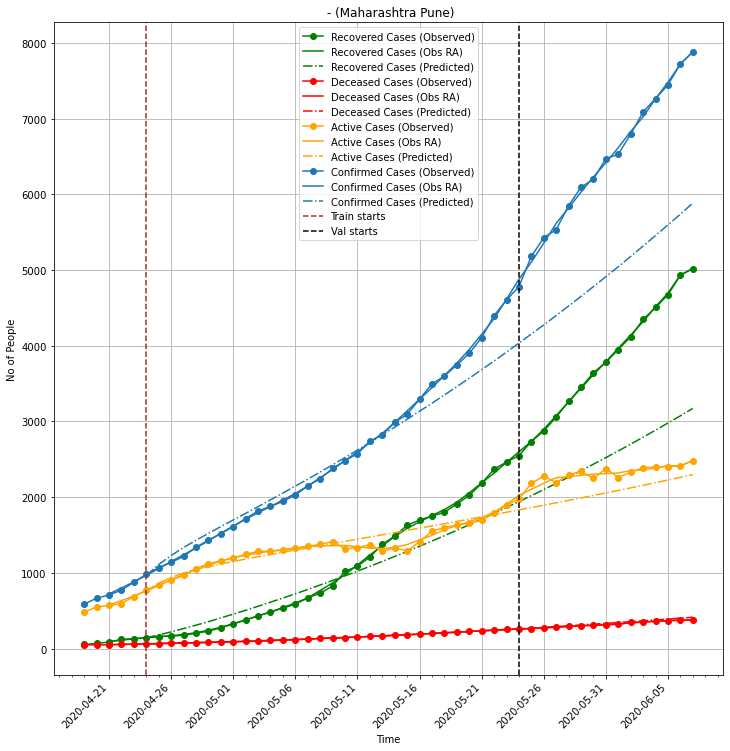

In [62]:
predictions_dict_3 = dict()

observed_dataframes = data_setup(input_3[0], input_3[1], val_period)

# print('train\n', observed_dataframes['df_train']) 
# print('val\n', observed_dataframes['df_val'])

predictions_dict_3['m1'] = run_cycle(
        st, dist, observed_dataframes, 
        model=model, variable_param_ranges=variable_param_ranges,
        data_from_tracker=data_from_tracker, train_period=train_period, 
        which_compartments=which_compartments, N=N,
        num_evals=num_evals, initialisation=initialisation
    )

In [63]:
t3 = predictions_dict_3['m1']['df_loss'].T[['hospitalised', 'deceased', 'recovered', 'total_infected']]
t3['exp'] = 3
predictions_dict_3['m1']['df_loss']

,train,val
hospitalised,4.87676,12.0941
total_infected,5.5824,29.756
deceased,1.32027,4.42891
recovered,21.5348,48.3631


In [64]:
t = pd.concat([t1, t2, t3], axis=0)
t.index.name="index"
t.sort_values(by='index', inplace=True)
t.to_csv(output_folder+"/exp_"+"_".join(replace)+".csv")

## Extra

In [65]:
# df_true = input_df[0]

# start_date_pd = pd.to_datetime(start_date, dayfirst=False)

# threshold = start_date_pd - timedelta(days=1)

# _, df_true = train_test_split(df_true, threshold)

# df_true

In [66]:
# lc = Loss_Calculator()
# df_predictions_1 = get_forecast(predictions_dict_1, train_fit="m1")
# df_loss_1 = lc.create_loss_dataframe_region(df_true, None, df_predictions_1, train_period, 
#                                             which_compartments=which_compartments)
# plot_forecast_agnostic(df_true, df_predictions_1.head(30), dist, st)

In [67]:
# df_loss_1

In [68]:
# df_predictions_2 = get_forecast(predictions_dict_2, train_fit="m1")
# df_loss_2 = lc.create_loss_dataframe_region(df_true, None, df_predictions_2.iloc[14:21], train_period, 
#                                             which_compartments=which_compartments)
# plot_forecast_agnostic(df_true, df_predictions_2.head(30), dist, st)

In [69]:
# df_loss_2

In [70]:
# df_predictions_3 = get_forecast(predictions_dict_3, train_fit="m1")
# df_loss_3 = lc.create_loss_dataframe_region(df_true, None, df_predictions_3.iloc[14:21], train_period, 
#                                             which_compartments=which_compartments)
# plot_forecast_agnostic(df_true, df_predictions_3.head(30), dist, st)

In [71]:
# df_loss_3